In [2]:
#! pip install fonttools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 7.0 MB/s 


In [1]:
import os
import random
import string
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
from tqdm import tqdm
from io import BytesIO
from toolz.curried import *
import requests

In [2]:
from fontTools.ttLib import TTFont
from fontTools.unicode import Unicode

In [3]:
#! git clone https://github.com/fatihkaan22/ocr-digital-display/

In [105]:
paths = {
  'fonts': os.path.join('/home/jupyter/ocr-digital-display','synthetic-data-generation', 'fonts'),
#  'drive_ws': os.path.join('drive', 'MyDrive', 'cse496', 'Tensorflow', 'workspace', 'synthetic-data-single-font'),
  'ws_dataset': os.path.join('/home/jupyter/ds/synthetic'),
}

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [72]:
def get_wordlist():
  word_site = "https://www.mit.edu/~ecprice/wordlist.10000"
  response = requests.get(word_site)
  return response.content.splitlines()

WORDS = get_wordlist()
# ALPHAS = [':', '.'] # TODO: &
ALPHAS = []

def char_list():
  return concatv(
      string.ascii_letters,
      string.digits,
      ALPHAS
  )

def supported_chars(ttfont):
  return pipe(
    ttfont,
    lambda f: f['cmap'].tables,
    map(lambda x: x.cmap.items()),
    merge,
    lambda d: list(d.keys()),
    filter(lambda char_code: chr(char_code) in char_list()),
    list
  )

def is_supported(charset, font):
  return set(
      map(ord)(charset)
    ).issubset(supported_chars(font))
    
def random_string_from_charset(charset):
  return pipe(
      range(random.randrange(5,15)),
      map(lambda _: random.choice(charset)),
      reduce(lambda a, b: str(a) + str(b)),
  )

def random_digits():
  return random_string_from_charset(string.digits)

def random_word():
  return pipe(
      WORDS,
      random.choice,
      lambda bs: bs.decode("utf-8") 
  )

# TODO: test curry
def supported_filter(font):
  def test(string):
    return is_supported(string, font)
  return test

def sample_text(font):
  return pipe([
#      random_string_from_charset(list(string.digits) + ALPHAS),
#      random_word(),
      random_digits()
    ],
    filter(supported_filter(font)),
    filter(supported_filter(font)),
    list,
    lambda x: random.choice(x) if len(x) > 0 else ''
  )

In [73]:
# TODO: unused
def is_digits_supported(font):
  return is_supported(string.digits, font)

# TODO: unused
def is_letters_supported(font):
  return is_supported(string.ascii_letters, font)

# TODO: unused
def is_alphas_supported(font):
  return is_supported(ALPHAS, font)

# TODO: unused
def random_gibberish(font):
  return pipe(
      range(random.randrange(5,15)),
      map(lambda _: chr(random.choice(supported_chars(font)))),
      reduce(lambda a, b: str(a) + str(b)),
  )

In [92]:
def draw_sample(font_path):
  word = sample_text(TTFont(font_path))
  font = ImageFont.truetype(font_path, random.randrange(25, 34))
  img = Image.new("RGBA", (512,512),(255,255,255))
  draw = ImageDraw.Draw(img)
  xy = (random.randrange(5, 100), 
        random.randrange(10, 400))
  draw.text(xy,word,(0,0,0),font=font)
  draw = ImageDraw.Draw(img)
  objects = []
  for i, char in enumerate(word):
    right, bottom = font.getsize(word[:i+1])
    width, height = font.getmask(char).size
    right += xy[0]
    bottom += xy[1]
    top = bottom - height
    left = right - width
    #draw.rectangle((left, top, right, bottom), None, '#f00')
    objects.append({
        'name': str(char),
        'xmin': left,
        'xmax': right,
        'ymin': top,
        'ymax': bottom
    })
  return {'img': img, 'text': word, 'font': font.getname(), 'objects': objects, 'path': font_path}

def generate_data(fonts, sample_count=1):
  return pipe(
      fonts,
      mapcat(lambda font: pipe(
          range(sample_count),
          map(lambda _: font),
          map(draw_sample),
      )),
  )

def get_font_path(filename):
  return os.path.join(paths['fonts'], filename)

font_paths = map(get_font_path)(os.listdir(paths['fonts']))

#for d in generate_data(font_paths, 1):
#  print(d['text'])
#  print(d['font'])
#  display(d['img'])

In [89]:
import xml.etree.cElementTree as ET
from xml.dom import minidom

def prettify(elem):
    rough_string = ET.tostring(elem, 'utf-8')
    reparsed = minidom.parseString(rough_string)
    return reparsed.toprettyxml(indent="  ")

def generate_xml_annotation(filename, im_width, im_height, bboxes):
    try:
        annotation = ET.Element('annotation')
        ET.SubElement(annotation, 'filename').text = filename
        size = ET.SubElement(annotation, 'size')
        ET.SubElement(size, 'width').text = str(im_width)
        ET.SubElement(size, 'height').text = str(im_height)
        ET.SubElement(size, 'depth').text = '3'

        for index, box in enumerate(bboxes):
            objectBox = ET.SubElement(annotation, 'object')
            ET.SubElement(objectBox, 'name').text = box['name']
            ET.SubElement(objectBox, 'pose').text = 'Unspecified'
            ET.SubElement(objectBox, 'truncated').text = '0'
            ET.SubElement(objectBox, 'difficult').text = '0'
            bndBox = ET.SubElement(objectBox, 'bndbox')
            ET.SubElement(bndBox, 'xmin').text = str(box['xmin'])
            ET.SubElement(bndBox, 'ymin').text = str(box['ymin'])
            ET.SubElement(bndBox, 'xmax').text = str(box['xmax'])
            ET.SubElement(bndBox, 'ymax').text = str(box['ymax'])

        et = ET.ElementTree(annotation)
        return prettify(annotation)
    except Exception as e:
        print('Error to generate the XML for image {}'.format(filename))
        print(e)

In [90]:
import uuid

def random_id():
  return str(uuid.uuid4())[:8]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  if sys.path[0] == "":


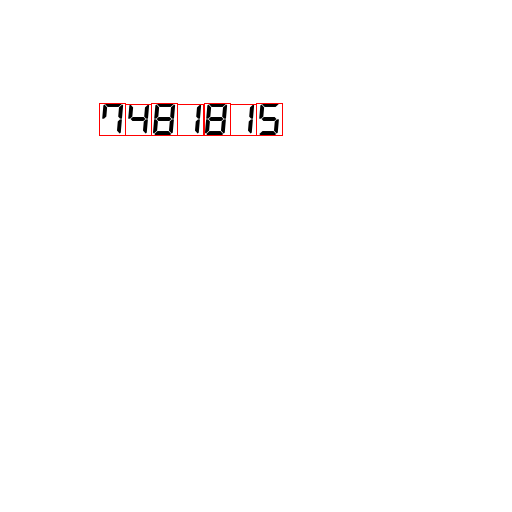

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7Classic-BoldItalic.ttf


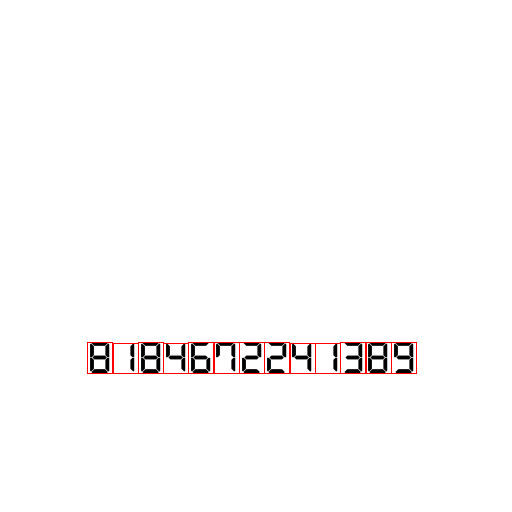

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7Classic-Bold.ttf


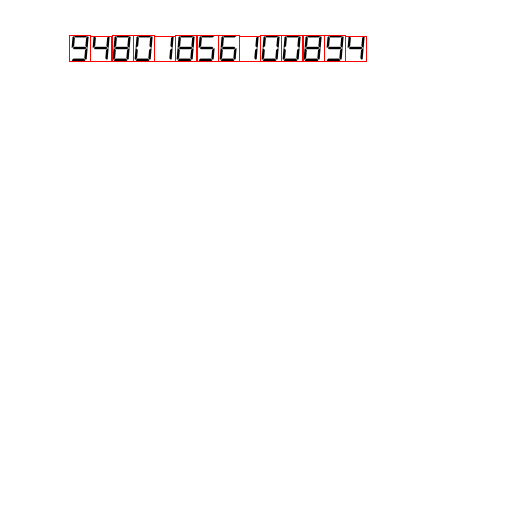

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7Classic-Italic.ttf


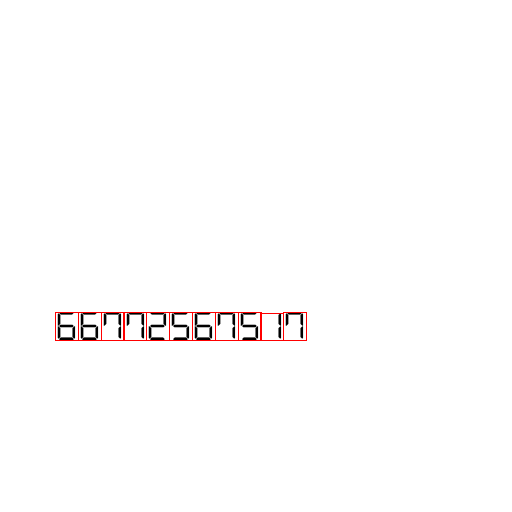

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7Classic-Regular.ttf


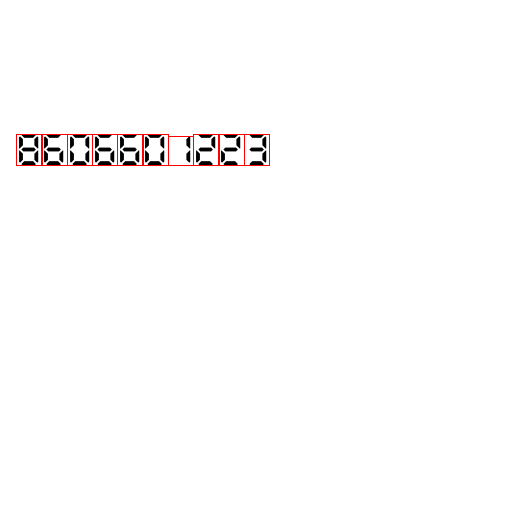

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7ClassicMini-Bold.ttf


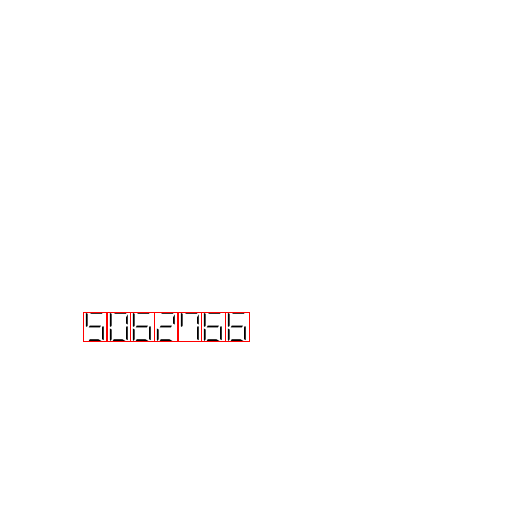

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7ModernMini-Light.ttf


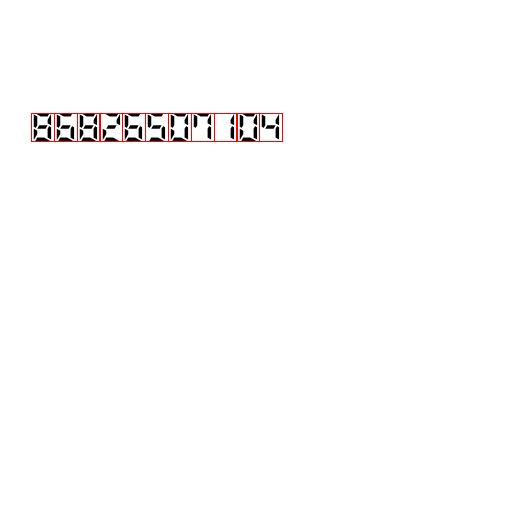

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7ModernMini-Bold.ttf


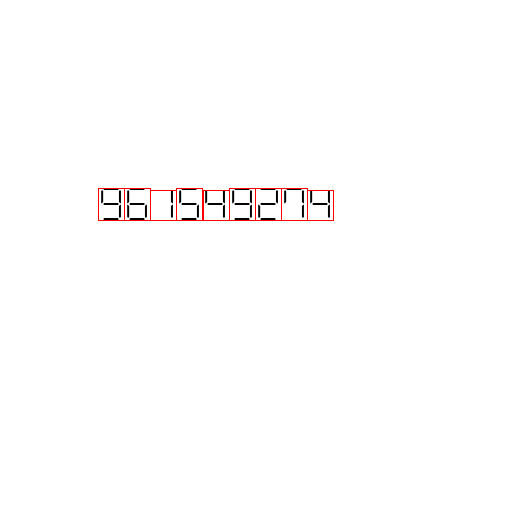

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7ClassicMini-Light.ttf


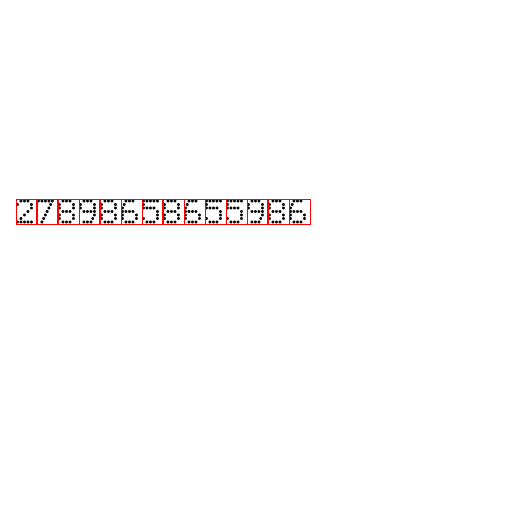

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DOTMATRX.TTF


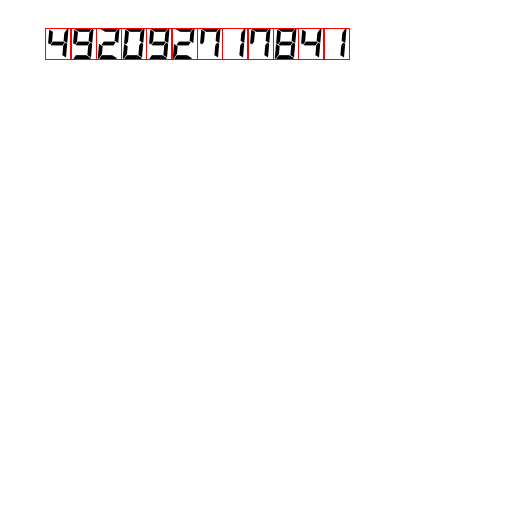

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7Modern-BoldItalic.ttf


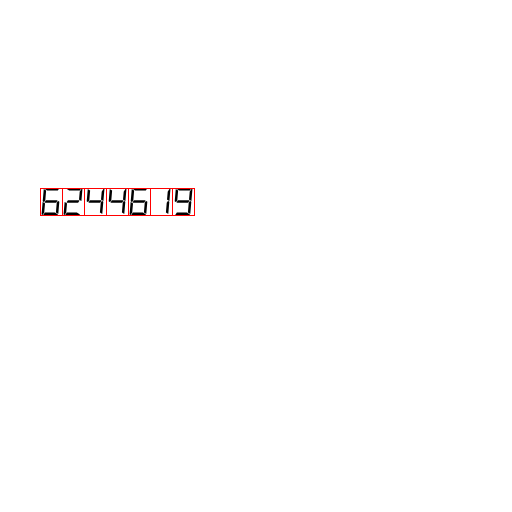

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7Modern-Italic.ttf


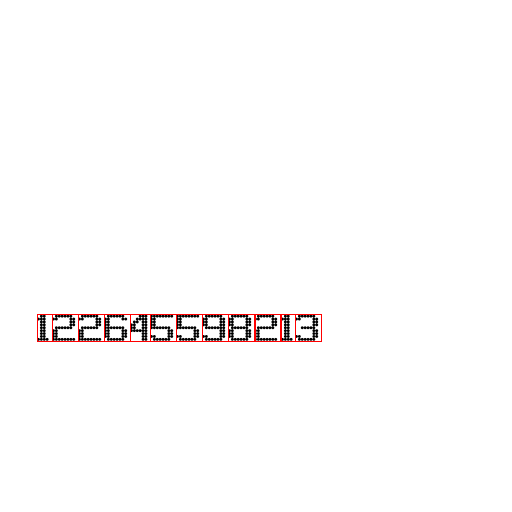

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/dot_matrix_bold_tall.ttf


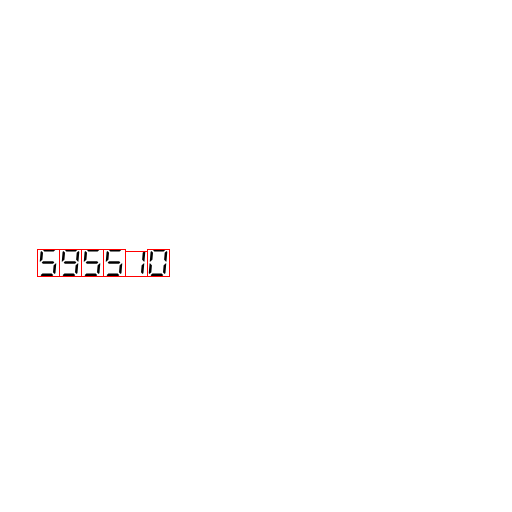

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7ClassicMini-Italic.ttf


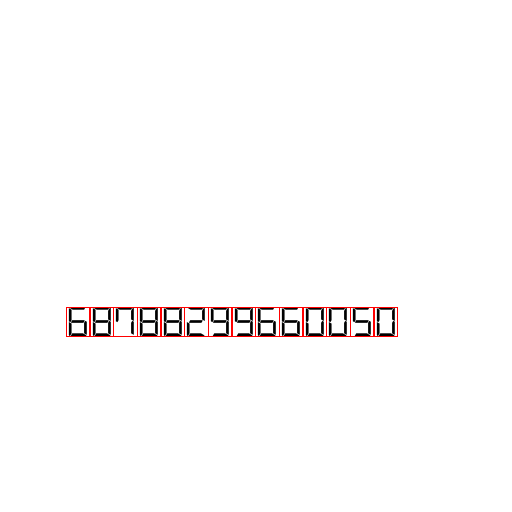

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/DSEG7Modern-Regular.ttf


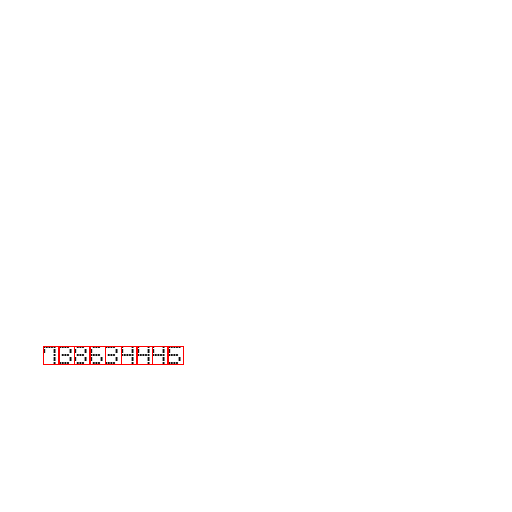

/home/jupyter/ocr-digital-display/synthetic-data-generation/fonts/led_counter-7.ttf


In [91]:
xs = [
    'DSEG7Classic-BoldItalic.ttf',
    'DSEG7Classic-Bold.ttf',
    'DSEG7Classic-Italic.ttf',
    'DSEG7Classic-Regular.ttf',
    'DSEG7ClassicMini-Bold.ttf',
    'DSEG7ModernMini-Light.ttf',
    'DSEG7ModernMini-Bold.ttf',
    'DSEG7ClassicMini-Light.ttf',
    'DOTMATRX.TTF',
    'DSEG7Modern-BoldItalic.ttf',
    'DSEG7Modern-Italic.ttf',
    'dot_matrix_bold_tall.ttf', 
    'DSEG7ClassicMini-Italic.ttf', 
    'DSEG7Modern-Regular.ttf', 
    'led_counter-7.ttf'
]

#xs = [get_font_path(i) for i in os.listdir(paths['fonts'])]

for d in generate_data(map(get_font_path)(xs)):
    display(d['img'])
    print(d['path'])

In [107]:
def create_data_folder(base_path, size):
  for i in tqdm(range(size)):
    for d in generate_data(map(get_font_path)(xs)):
      #display(d['img'])
      #print(d['text'])
      filename = random_id()
      path = f'{base_path}/{filename}'
      d['img'].save(f'{path}.png')
      xml_string = generate_xml_annotation(f'{filename}.png', 512, 512, d['objects'])
      with open(f'{path}.xml', 'w') as file:
        file.write(xml_string)

def train_test_size(n, ratio):
  test = int(ratio * n)
  train = n - test
  return train, test

train_size, test_size = train_test_size(100, 0.2) # 100 x number of fonts (15) = 1500

create_data_folder(os.path.join(paths['ws_dataset'], 'train'), train_size)
create_data_folder(os.path.join(paths['ws_dataset'], 'test'), test_size)


  0%|          | 0/80 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  if sys.path[0] == "":
100%|██████████| 20/20 [00:05<00:00,  3.93it/s]
